# Chapter 4 - Camera Calibration

This article discusses how one can derive the perspective of a camera by the given landmarks. Also, it explains how 
many of such landmarks are needed to be able to get the correct perspective and also explains the different methods 
for calibrated and uncalibrated cameras. Uncalibrated cameras are ones for which we don't know the accurate intrinsic 
parameters. We explain how camera calibration works, so how we can find the intrinsics and what aspects are important 
for this.

## Perspective from *n* Points (PnP Problem)

The goal of **Perspective from n Points** algorithms is to find the pose of the camera in respect to the world reference 
frame. This means we want to find the six degrees of freedom describing the position and orientation of the camera. 
As input we have the landmarks in the world reference frame as well as their images on the camera plane. 
In the case of an uncalibrated camera we additionally want to find out the camera's intrinsic parameters which we have 
discussed already in chapter 3.

Let's now find out how many points we need to get a unique solution. First, we look into the case of a calibrated camera.

##### One Point

First for only one point for which we know the position in the world and the position on the image plane of the camera 
we have infinite possible solution. This is because the camera can be placed all around that point in the world 
with any distance from it. We see that the point on the camera plane is always at the same image coordinates independently from where we place the camera as long the relative location from the camera plane to the ray from C to the world point is the same.

![1 Point](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/0_P1P.png)
*Figure 0: 1 Point (P1P). [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

##### Two Points

For two points we know the actual distance between the points in the world as well as for the ones on the image plane. 
Because of the fixed focal length of the camera we know the angle between the two points in the image plan and the 
camera. From the intrinsics we also know the position of the image origin (u<sub>0</sub>/v<sub>0</sub>). The formula for the angle follows from the normal tangent formula and the use of the triangle Cp<sub>1</sub>(u<sub>0</sub>/v<sub>0</sub>) and is:

\begin{align*}
\theta = tan^{-1}(\dfrac{d_1+s_1}{f}) - tan^{-1}(\dfrac{d_1}{f})
\end{align*}

![1 Point](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/angle_from_f.png)


Therefore, the camera can only be at places where the world points lie on the two lines connecting the camera point 
with the two image points. As a result, we know the geometric figure describing all possible position for the 
camera points have to be rotationally symmetrical around the axis described by the line that intersects both world points. 
To find the exact geometrical figure we now inspect the figure that is rotated. The only figure that fulfills 
the condition that the angle of the lines connecting the world points with the camera points through the image point on 
a plane is the circle. Therefore, we have now found the correct geometrical figure in 3D that describes the possible 
location the camera can have when we have given 2 points. It is called "spindel torus".
For a continuous reference frame this results still in a infinite number of possible positions but at least we 
know that it is bounded.


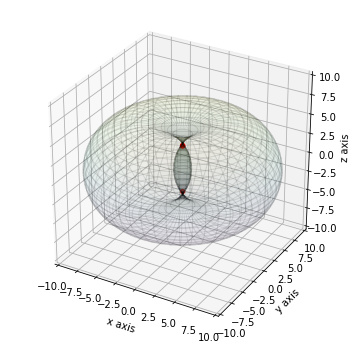

In [1]:
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

u=np.linspace(0,2*np.pi,100)
v=np.linspace(0,2*np.pi,100)
u,v=np.meshgrid(u,v)
a = 6
b = 5
X = (b + a*np.cos(u)) * np.cos(v)
Y = (b + a*np.cos(u)) * np.sin(v)
Z = a * np.sin(u)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
#ax.set_aspect('equal')

ax.scatter([0,0], [0,0], [-3,3], c='r', marker='o')
ax.plot_surface(X, Y, Z,alpha=0.05, cmap='viridis', edgecolor='black')
ax.scatter([0,0], [0,0], [-3,3], c='r', marker='o')

plt.show()

##### Three Points

Let us now try it with three points. Again, we draw lines from the points in the world reference frame through tier 
image on the camera plane. Dependent on where we place the camera these lines can intersect each other. In the case 
where all three lines intersect in one single point, we have found a valid place for the camera point to be. To derive 
how many solutions there are and how to find them we take advantage of the law of cosine. In the previously described 
situation we have three different triangles with their corners at two of the world-points and one at the camera 
center. Also, for these triangles two edges intersect the camera plane at the image-points. The law of cosine states 
that for each triangle the squared distance between the two image points *s<sub>i</sub>* is equal to the sum of the squared distance both edges connecting the image points with the camera center subtracting the twice the product of the times the cosine of the angle at the camera center.

\begin{align*}
{s_i}^2={A_i}^2+{B_i}^2 - 2A_iB_icos(\theta_i)
\end{align*}

Given by the points in the world reference frame we know s<sub>i</sub> and θ<sub>i</sub> is given by the points on the image plane and the focal length given by the camera intrinsics. We see that each of these equations has degree two. In total we have three unknows since A<sub>2</sub> = B<sub>1</sub>, A<sub>3</sub> = B<sub>2</sub>, A<sub>1</sub> = B<sub>3</sub> and we also have three equations. For systems with *n</t>* independent non-linear equations and *n</t>* variables it is know that the number of solutions has an upper bound equal to the product of the degrees of the equations. In our case this results to 2<sup>3</sup>=8. Due to the second degree of the equations we know that for every positive solution there is also a negative solution. So, given that we expect the camera plane to be in between the world points and the camera point there are only 4 possible solutions.
So, to get an unambiguous solution we need a 4th point. 

Worth mentioning is also the system of the three equation can also be reformulated into a system with degree 4. 

\begin{align*}
G_0 + G_1x + G_2x^2 + G_3x^3 + G_4x^4
\end{align*}

Since we only need three points to get down to 4 solutions the PnP is often also referred to as P3P however as we have seen this is not completely correct as we need one more point to get an unambiguous solution. So P3+1P would fit best as a name.

![3 Points](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/P3P.png)
*Figure ...: 3 Points. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*


## DLT - Camera calibration

In the section about the PnP we assumed the angle between image points and camera center as given. However, for getting this angle we need the focal length, which is unique to each camera, however we only know the exact focal length in the case of a calibrated camera. So, what do we do when we don't know the camera's instrinsic? Well we have to get them first using the **Direct Linear Transform (DLT)**

So, our goal is to compute the camera intrinsics K, R and T. We know that the intrinsics have to fulfill the projection equation which we looked at in Chapter 3. Remember that p ̃ the image point locations in homogeneous coordinates.

![Projection equation part 1](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/1_projection_equation.png)
![Projection equation part 2](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/2_projection_equation_part2.png)
*Figure 1: Projection Equation. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

The matrix with the twelve entries m<sub>ij</sub> is called M. We can also write each row of M as m<sub>i</sub><sup>T</sup> so, 

\begin{align*}
\begin{bmatrix} m_{i1} & m_{i2} & m_{i3} & m_{i4} \end{bmatrix}= {m_i}^T
\end{align*}

Also we denote 

\begin{align*}
\begin{bmatrix} X_w \\ Y_w \\ Z_w \\ 1 \end{bmatrix}
\end{align*}

as *P*

To get back to the normal pixel coordinates *u</t>* and *v</t>* we have to normalize homogeneous coordinates in respect of the third dimension.

![Homogeneous to pixel coordinates part1](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/3_homogeneous_to_pixel.png)
*Figure 2: Conversion homogeneous to pixel coordinates. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

Now we can insert *i=1</t>* and swap the positions of *m</t>* and *P</t>*. When we do this for all *i</t>* we get a large (2n x 3) matrix equation. This large Matrix is also called *Q</t>*.

![Matrix equation](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/4_matrix_equation.png)
![Matrix equation part2](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/5_matrix_equation_part2.png)
![Matrix equation part3](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/6_matrix_equation_part3.png)
*Figure 3: Q matrix. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

Please take note that the entries in the vector are no longer m<sub>i</sub><sup>T</sup> but m<sub>i</sub>, so they are no longer transposed which means that the second matrix in not a matrix but rather a vector.

When solving this equation system, we know that for getting a unique solution then the matrix *Q</t>* need one less rank than it has rows. Therefore, it need to have rank 11. So, the question now is how many points do we need to be able to create a Q matrix with rank 11? Well each point provides 2 equations, so as a result we need at least 5.5 points which obviously does not work out. So therefore at least 6 points are required to be able to calculate the camera's intrinsics. In practice one can use Singular Value Decomposition for calculating the solution for the vector *M</t>*.  **Todo: explain svd method that m correspondence to last eigenvector.**

Now we need to recover the intrinsics from the Matrix *M</t>*. The following relation can be used.
![Matrix equation part2](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/7_M_to_K_part1.png)
![Matrix equation part3](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/8_M_to_K_part2.png)
*Figure 4: recover K,R and T. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*


However, he above formula does not enforce R to be orthogonal. Therefore in practice we use the QR decomposition to decompose M (the first three columns) into a orthogonal matrix which is then the real R and the rest which incorporates K. Lets say Q<sup>~</sup> and R<sup>~</sup> are the solutions to the QR decomposition. Then the rotation matrix *R</t>* is equal to Q<sup>~</sup> and the intrinsics *K</t>* is equal to R<sup>~</sup>. 

\begin{align*}  
R & = \widetilde{Q}\\
K & = \widetilde{R} \\
T & = -K^{-1}M 
\end{align*} 

And the translation matrix can be derived from *M</t>* and *K</t>*

Now we know that we need at least six points to be able to calculate the intrinsics. However, the correct number of points is not a guarantee for getting the correct solution. The points have to fulfill certain conditions. First, they aren’t allowed to be all on one plane (coplanar). Another invalid constellation is when all points lie on a line that also goes through the center of projection, however this case is covered by the restriction of not being coplanar.
Another more complex case is that the points and the center of projection are not allowed to be an the same twisted cubic.


### Intermezzo about SVD

Let’s say the SVD decomposes a matrix $A$ as follows:
\begin{align*}  
A= UWV^T
\end{align*} 

then we can sole a system *Ax=b* as follows:

\begin{align*}  
Ax &= b\\
UWV^Tx &= b\\
(VW^{-1}U^T)UWV^Tx &= (VW^{-1}U^T)b\\
VW{-1}(U^TU)WV^Tx &= VW^{-1}U^Tb\\
V(W{-1}W)V^Tx &= VW^{-1}U^Tb\\
VV^Tx &= VW^{-1}U^Tb\\
x &= VW^{-1}U^Tb\\
\end{align*} 



## Camera Calibration methods

### Tsai's camera calibration example (1987)

Given the DLT algorithm from above we can easily calculate the intrinsics. A camera calibration example that was introduced by Tsai in 1987 uses two grids that are orthogonal to each other to present clear corners which then can be detected and be used as the underlying world points for the above DLT algorithm. As we have seen at least 6 points are needed, however the approach can be improved by using more points (ideally more than 20). Worth mentioning is that back then one had to consider that the pixel was not actually square but rectangular and therefore different focal length α<sub>u</sub> and α<sub>v</sub> had to be considered.
Today one can assume α<sub>u</sub> = α<sub>v</sub> and therefore K<sub>12</sub>=0. How do we know how well is our calibration you may ask? Well we can user the residual which is the average reprojection error as a metric. The reprojection error is the pixel distance between the actual image and the reprojection of the world point onto the image plane.



### Calibration from planar Grids

Tsai used the DLT algorithm for the calibration which required the points in the world reference frame to not be one a single plane as we have showed in the section about the DLT. Today’s standard camera calibration methods however user planar grids. This method was developed by Zhang (1999) at the Microsoft Research. It is based on the camera taking pictures of that planar grid from different orientations. This means that in practice for a fixed camera position the planar grid is moved in front of the camera into different orientations and rotations. But how does this method work?

We start of like the DLT where we note down the perspective projection equation. However, this time the world coordinates do not have any numerical value to the Z-coordinate since we are on a planar grid.

![planar perspective projection part1](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/9_planar_perspective.png)
![planar perspective projection part2](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/10_planar_perspective_part2.png)
*Figure 5: planar perspective projection equation [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

The matrix H is called "Homography". We apply exact the same steps as we did for the DLT. Just his time instead of the Matrix M which is (4X3) we have H which is 3x3

![Matrix equation](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/11_planar_matrix_equation.png)
![Matrix equation part2](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/12_planar_matrix_equation_part2.png)
![Matrix equation part3](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/13_planar_matrix_equation_part3.png)
*Figure 6: ... [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

Similar to the DLT we can derive the minimum number of needed points from the rank of Q. For a unique, non-trivial solution *Q</t>* hast to have rank 8. Therefore, we need at minimum 4 non-collinear points. 
We can get the intrinsics by remembering that *H = KR</t>*. First, we get multiply Homographies H<sub>i</sub> from different views.



This won't be asked:

Lets say *H<sub>i</sub>∼K(r<sub>1</sub>,r<sub>2</sub>,t)*. Now we define *w<sub>1</sub>=Kr<sub>1</sub>* and *w<sub>2</sub>=Kr<sub>2</sub>*. Now we can buld the equations:

\begin{align*}
{w_1}^TB{w_1}-{w_2}^TB{w_2} &= 0 \\
{w_1}^TB{w_2} &= 0
\end{align*}

Where *B = K<sup>-T</sup>K<sup>-1</sup>*. We cann stack all of these equations for each of the N homographie and therefore get a system of *2N</t>* equations which is a liner system of form *Ab=0</t>* which we can solve for *b</t>* (B) using the Singular Value Decomposition. Then we can use the Cholesky decomposition to get *K</t>* from *B</t>*.



### Homography

Homography is a projective transformation which has 8 degrees of freedoms (D.O.F). The only attribute that is preserved is that straight line stay straight. 

![Types of 2D Transformations](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/14_types_of_2d_transformations.png)
*Figure 7: Types of 2D Transformations [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*


### DLT vs PnP

In the case of already calibrated cameras applying the PnP is more accurate in terms of rotation error as well as translation error. Also, the general PnP algorithm is faster than DLT. Since DLT uses SVD and use the smallest eigenvalue, which is the best possible solution, but it is still an approximation unless this eigenvalue is 0 therefore the result is not exact. PnP however uses an absolute solution.

### Omnidirectional Camera

Omnidirectional Cameras are ones with a very large Field of view (FOV)

![Fisheye and Catadioptric](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/15_omnidir_camera.png)
*Figure 8: Fisheye and Catadioptric [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

Catadioptric cameras use a bowl-shaped mirror which allow to reflect a 360-degree view onto the camera plane. However, in the center a blind spot remains where the camera itself is reflected. There are multiple different shapes possible for that mirror. One Issue that can arise is that the shape of the mirror produces a reflection where the rays no not intersect in a single point. Cameras with this property are called Non-central catadioptric cameras.

![non-central Catadioptric](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/16_noncentral_catadipotric.png)
*Figure 9: non-central Catadioptric [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

Non-central projection is not preferable because one cannot apply standard algorithms for perspective geometry and the image cannot be unwarped into a perspective image where the projection attributes can be applied. For a central projection one can transform the image points onto a unit sphere.

Central projection can be achieved by different combinations of mirror shapes and camera types.

![Central Catadioptric](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/17_central_catadipotric.png)
*Figure 10: Central Catadioptric [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

Perspective and Central Catadioptric cameras are really equivalent as the following image shows.

![Equivalence between Perspective and Central Catadioptric model](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/18_equivalence_omnidir_perspective.png)
*Figure 11: Equivalence between Perspective and Central Catadioptric model [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*

![...](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/Unified_Omnidirectional_Camera_Model.png)
[source](http://rpg.ifi.uzh.ch/docs/teaching/2019/03_image_formation_2.pdf)*



### Implementing DLT

In the following we will show how you can implement the DLT algorithm to estimate the pose of the camera from a set of given 2D-3D correspondences.

We start of with writing a method that produces the matrix M of the DLT algorithm

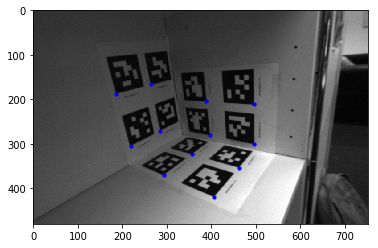

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cameras intrinsic parameters [K] (f~420px, w~710px, h~500px)
K = np.array(
    [[420.506712, 0.,          355.208298],
     [0.,         420.610940,  250.336787],
     [0.,         0.,          1.]]
)

# (n = 12) reference 3D points, in the world coordinate, in centimeters
world_corners = 0.01* np.array(
    [[19.4, 9.0,   19.4, 9.0,     19.4,   9.0,     19.4,   9.0,   0.0,   0.0,   0.0,   0.0], #Y
     [0.,   0.,   0.,   0., 10.95, 10.95, 24.45, 24.45, 10.95, 24.45, 10.95, 24.45], #X
     [18.6,   18.6, 5.1, 5.1,   0.0,   0.0,   0.0,   0.0,   12.0,   12.0,    1.6,    1.6]] #Z
)

detected_corners = np.array(
    [[186.5, 264.5, 218.5, 285.5, 292.5, 356.5, 406.5, 461.5, 388.5, 495.5, 396.5, 496.5],
     [187.5, 166.5, 304.5, 270.5, 369.5, 322.5, 418.5, 353.5, 204.5, 211.5, 280.5, 300.5]]
)


# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('img/chapter_4/img_0001.jpg')[:,:,0]
plt.imshow(img, cmap='gray')
plt.scatter(x=detected_corners[0], y=detected_corners[1], c='b', s=10)

plt.show()



In [3]:
def DLTPoseEstimation(image_points, world_points, K):
    """
    Estimate the pose of the camera from the given 2D-3D correspondences 
    and the given camera intrinsics.
    :param np.ndarray[float, float] image_points:      vector of undistorted image coordinates
    :param np.ndarray[float, float] world_points:    vector of world coordinates
    :param np.ndarray[float, float] K:               camera matrix, intrinsics
    :return: projection matrix M [R|t] with R (Rotation matrix) t (translation)
    :rtype: np.array(...)
    """
    # convert 2D points to 3D points by adding 1 to the third dimension
    image_3d = np.concatenate((image_points, np.ones((1,len(image_points[0])))), axis=0)
    
    # normalize the coordinates by applying the camera intrinsics
    image_points_normalized = np.linalg.solve(K, image_3d)
                               
    # create Q matrix to fill, initialize with zeros
    Q = np.zeros((2*len(image_points_normalized[0]), 12))
        
    # fill the Q-amtrix according to its definition
    for i in range(len(image_points_normalized[0])):
        u = image_points_normalized[0,i]
        v = image_points_normalized[1,i]
        
        Q[2*i,:3] = world_points[:,i]
        Q[2*i,3] = 1
        Q[2*i,8:11] = -u*world_points[:,i] 
        Q[2*i,11] = -u    
                               
        Q[2*i+1,4:7] = world_points[:,i]
        Q[2*i+1,7] = 1
        Q[2*i+1,8:11] = -v*world_points[:,i] 
        Q[2*i+1,11] = -v
           
    # solve the system Q*M = 0 for M
    u_of_M, s_of_M, vh_of_M = np.linalg.svd(Q)
    # reshape the vector to be 3x4 for the projection matrix M
    M = np.array(vh_of_M[-1,:]).reshape((3, 4))

    # extract the rotation matrix R
    R = M[:,0:3]
    # ensure that the determinant of R is positive. if not multiply M (and R) with -1
    if (np.linalg.det(R)) < 0:
        M = -M
        R = -R
            
    
    # We have to make sure the R is a real rotation matrix so that all eigenvalues are 1
    # so achieve this we use the SVD (R=USV) and multiply the solution together 
    # but with the identity matrix instead of S (R_tilde=UV)
    # TODO use QR
    u_of_R, s_of_R, vh_of_R = np.linalg.svd(R)
    R_tilde = np.matmul(u_of_R,vh_of_R)

    # what we have so far is a projection matrix without the correct scaling factor
    # we can get the scaling alpha by deviding the norm of R_tilde ba the norm of R
    alpha = np.linalg.norm(R_tilde)/np.linalg.norm(R)

    # Now we can put together the final M_tilde=[R_tilde|alpha*t]
    M_tilde = np.concatenate((R_tilde, alpha*M[:,3].reshape(3,1)), axis=1)
    return M_tilde

def worldToPixels(world_points, M, K):
    """
    Convers a vector in world coordinates to uv pixel coordinates (Reprojection)
    :param np.array(x, y, z, 1) Pw:     World vector 
    :return: (u,v) pixel coordinates of world point in image frame
    :rtype: Tuple[number, number]
    """
    world_points_4d = np.concatenate((world_points, np.ones((1,len(world_points[0])))), axis=0)

    Pc = np.matmul(M, world_points_4d)
    Pc_norml = (Pc / Pc[2])
    p = np.matmul(K, Pc_norml)
    uv = p[:-1]
    return uv[0], uv[1]



Now that we have constructed a method for the DLT algorith we can verify wether it works as expected or not.
For this we reproject the cornerpoints for with we have the world coordinates onto the image and check if they are correcly positioned on the image.

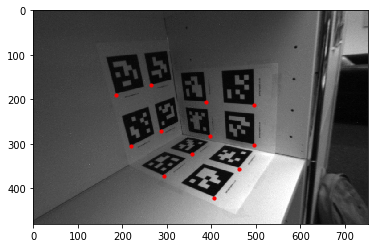

In [4]:
# get the projection matrix
M_dlt = DLTPoseEstimation(detected_corners, world_corners, K);
# reproject the world point onto the image
reprojected_points = worldToPixels(world_corners, M_dlt, K)

# load the image in gray-scale and plot the reprojected points onto it.
img = mpimg.imread('img/chapter_4/img_0001.jpg')[:,:,0]
plt.imshow(img, cmap='gray')
plt.scatter(x=reprojected_points[0], y=reprojected_points[1], c='r', s=10)
plt.show()

We see that our reprojected 3D point are positioned reasonably well.

### Recover camera position

In the above code we have produced a projection matrix which transforms from the world reference frame to the image frame and used it to reproject knowm 3D points. Now we want to use the same emthod to recover the position of the camera from the known 3D point positions and their detected image on the image plane. Since the projection matrix directly encorporates the camera position we can direcly get the position form $M$. However we have to be caseful since in the above method we have derive the projection from the World to the Image plane and now we want the have the world position of the camera. Therfore we have to invert the resulting projection.

With the following code we produce an animation showing the 3D position of the camera in each frame. As input we have the detected corners on the image plane for each frame as well as the world coordinates of those corner like before. The input is formatted like in the above example.

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# load the detected corners for each frame, the data is saved as a pickle.
with open('img/chapter_4/detected_corners_vector.pkl', 'rb') as f:
    detected_corners_all = pickle.load(f)

# create base plot    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=90)
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
ax.set_zlim(0,0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# plot the world coordinates of the corners
ax.scatter(world_to_true[0], world_to_true[1], world_to_true[2], c='r', cmap='Greens');

# create plot object which should be animated
graph, = ax.plot([],[],[], c='b', marker='o')
x_line, = ax.plot( [0,0], [0,0], [0,0], c='lime')
y_line, = ax.plot( [0,0], [0,0], [0,0], c='red')
z_line, = ax.plot( [0,0], [0,0], [0,0], c='blue')

# define the lines to represent the camera rotation
x_line_coords = [[0.05],[0],[0]]
y_line_coords = [[0],[0.05],[0]]
z_line_coords = [[0],[0],[0.05]]

def animate(i):
    # get the projection matrics using DLT
    detected_corner_in_frame = detected_corners_all[i]
    M = DLTPoseEstimation(detected_corner_in_frame, world_corners, K);
    
    # extract the rotation matrix and transpose it since we want to inverse the process
    # we also have to multiply with -1 since its determinant would not be 1 
    # otherwise and therefore it would not be a rotation matrix
    rot = -M[:,:3].transpose()
    # apply the rotation to the transplation part of M to recover the camera position
    pos = np.matmul(rot,M[:,3])

    # apply the same rotation to the line wused to represent the camera orientation
    x_line_rot = np.matmul(rot,x_line_coords)[:,0]
    y_line_rot = np.matmul(rot,y_line_coords)[:,0]
    z_line_rot = np.matmul(rot,z_line_coords)[:,0]

    # set the data for the animation
    graph.set_data(pos[0], pos[1])
    graph.set_3d_properties(pos[2])
    x_line.set_data([pos[0], pos[0]+x_line_rot[0]], [pos[1], pos[1]+x_line_rot[1]])
    x_line.set_3d_properties([pos[2], pos[2]+x_line_rot[2]])
    y_line.set_data([pos[0], pos[0]+y_line_rot[0]], [pos[1], pos[1]+y_line_rot[1]])
    y_line.set_3d_properties([pos[2], pos[2]+y_line_rot[2]])
    z_line.set_data([pos[0], pos[0]+z_line_rot[0]], [pos[1], pos[1]+z_line_rot[1]])
    z_line.set_3d_properties([pos[2], pos[2]+z_line_rot[2]])

# run and save animation
anim = FuncAnimation(fig, animate, frames=int(len(detected_corners_all)), interval=20)
anim.save('img/chapter_4/ani.gif', writer='imagemagick')

NameError: name 'pickle' is not defined

![camera](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/camera.gif)

![ani](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/ani.gif)

### Summary

- For Calibrated cameras the PnP P3P (Perspective from n Points) algorithm is used since the intrinsics are already know. The minimum number of points that are needed is 3+1.
- For uncalibrated camera the DLT (Direct Linear Transform) can be used since the intrinsics first have to be calculated. Here 4 coplanar or 6 non coplanar points are needed


In [ ]:
"""
detected_corners = np.loadtxt('img/chapter_4/detected_corners.txt')
print(detected_corners)
corners = []
for i in range(len(detected_corners)):
    corners.append(np.array((detected_corners[i][::2],detected_corners[i][1::2])))
print(corners)
with open('img/chapter_4/detected_corners_vector.pkl', 'wb') as f:
    pickle.dump(corners,f)
"""